Data Preprocessing

In [1]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split

# Step 1: Load the image data
def load_images(image_dir):
    images = []
    for filename in os.listdir(image_dir):
        if filename.endswith(".png"):  # Check if the file is a PNG image
            image_path = os.path.join(image_dir, filename)
            image = cv2.imread(image_path)
            if image is not None:
                images.append(image)
            else:
                print(f"Error loading image: {image_path}. Skipping...")
    return images

microbleed_images = load_images('big_roi_set/microbleed')
nonmicrobleed_images = load_images('big_roi_set/nonmicrobleed')

def load_labels(label_file):
    with open(label_file, 'r') as file:
        labels = [int(label.strip()) for label in file.readlines()]
    return np.array(labels)

microbleed_labels = load_labels('big_roi_set/microbleed_labels.txt')
nonmicrobleed_labels = load_labels('big_roi_set/non_microbleed_labels.txt')


# Step 1: Convert lists to NumPy arrays
microbleed_images = np.array(microbleed_images)
nonmicrobleed_images = np.array(nonmicrobleed_images)



# Step 2: Preprocess the data
# Normalize pixel values to range [0, 1]
microbleed_images = microbleed_images / 255.0
nonmicrobleed_images = nonmicrobleed_images / 255.0



# Step 3: Concatenate microbleed and nonmicrobleed data
X = np.concatenate((microbleed_images, nonmicrobleed_images), axis=0)
y = np.concatenate((microbleed_labels, nonmicrobleed_labels), axis=0)



# Step 4: Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)
# Print the shapes of training and testing sets
print("Training data shapes:", X_train.shape, y_train.shape)
print("Testing data shapes:", X_test.shape, y_test.shape)

(4979, 200, 200, 3)
(4979,)
(1245, 200, 200, 3)
(1245,)
Training data shapes: (4979, 200, 200, 3) (4979,)
Testing data shapes: (1245, 200, 200, 3) (1245,)


Res_Net Model

In [2]:
import tensorflow as tf

def convolution_block(inputs, filters, kernel_size=(5, 5), strides=(1, 1), padding='same'):
    conv = tf.keras.layers.Conv2D(filters=filters, kernel_size=kernel_size, strides=strides, padding=padding)(inputs)
    conv = tf.keras.layers.BatchNormalization()(conv)
    conv = tf.keras.layers.ReLU()(conv)
    return conv

def resnet_block(inputs, filters):
    x = convolution_block(inputs, filters)
    x = convolution_block(x, filters)
    
    # Adjust the number of channels in the inputs tensor
    adjusted_inputs = tf.keras.layers.Conv2D(filters=filters, kernel_size=(1, 1))(inputs)
    return tf.keras.layers.Add()([adjusted_inputs, x])

def resnet_model(input_shape=(200, 200, 3)):
    inputs = tf.keras.layers.Input(shape=input_shape)
    x = inputs
    for _ in range(9):
        x = resnet_block(x, filters=64)
        # Check if spatial dimensions allow pooling
        if x.shape[1] > 2 and x.shape[2] > 2:
            x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(x)
    x = tf.keras.layers.Conv2D(filters=1, kernel_size=(1, 1))(x)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)  # Add GlobalAveragePooling2D layer
    outputs = tf.keras.layers.Dense(units=1, activation='sigmoid')(x)  # Modify output layer
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model

# Instantiate ResNet model
resnet = resnet_model(input_shape=(200, 200, 3))  # Adjust input shape as needed
resnet.summary()

# Instantiate V-Net model
model = resnet_model(input_shape=(200, 200, 3)) 

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()

# Assuming you have X_train, y_train, X_test, y_test ready, you can train the model like this:
history = model.fit(X_train, y_train, epochs=10, batch_size=16, validation_data=(X_test, y_test))

# Evaluate the model
test_loss, test_acc = model.evaluate(X_test, y_test)
print("Test Accuracy:", test_acc)

# Save the model
resnet.save("resnet_model.h5")

In [ ]:
#include OUtput Scrollable (inputs, attrs)

V_NET

In [ ]:
import tensorflow as tf

def convolution_block(inputs, filters, kernel_size=(5, 5), strides=(1, 1), padding='same'):
    conv = tf.keras.layers.Conv2D(filters=filters, kernel_size=kernel_size, strides=strides, padding=padding)(inputs)
    conv = tf.keras.layers.BatchNormalization()(conv)
    conv = tf.keras.layers.ReLU()(conv)
    return conv

def vnet_encoder(inputs, levels=4, base_channels=8):
    x = inputs
    downsample_layers = []
    
    for level in range(levels):
        filters = base_channels * (2 ** level)
        for _ in range(2):
            x = convolution_block(x, filters)
        downsample_layers.append(x)
        if level < levels - 1:
            x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(x)
    
    return x, downsample_layers

def vnet_decoder(inputs, downsample_layers, levels=4, base_channels=8):
    x = inputs
    for level in reversed(range(levels - 1)):
        filters = base_channels * (2 ** level)
        x = tf.keras.layers.Conv2DTranspose(filters=filters, kernel_size=(5, 5), strides=(2, 2), padding='same')(x)
        x = tf.keras.layers.Concatenate(axis=-1)([x, downsample_layers[level]])
        for _ in range(2):
            x = convolution_block(x, filters)
    x = tf.keras.layers.Conv2D(filters=1, kernel_size=(1, 1), padding='same', activation='sigmoid')(x)  # Modify output layer
    x = tf.keras.layers.Reshape((-1, 1))(x)  # Reshape to (None, 1) instead of (200, 200, 1)
    return x


def vnet_model(input_shape=(200, 200, 3)):
    inputs = tf.keras.layers.Input(shape=input_shape)
    encoder_output, downsample_layers = vnet_encoder(inputs)
    decoder_output = vnet_decoder(encoder_output, downsample_layers)
    model = tf.keras.Model(inputs=inputs, outputs=decoder_output)
    return model

# Instantiate V-Net model
model = vnet_model(input_shape=(200, 200, 3)) 

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()

# Assuming you have X_train, y_train, X_test, y_test ready, you can train the model like this:
history = model.fit(X_train, y_train, epochs=10, batch_size=16, validation_data=(X_test, y_test))

# Evaluate the model
test_loss, test_acc = model.evaluate(X_test, y_test)
print("Test Accuracy:", test_acc)

# Save the model
model.save("vnet_model.h5")

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 200, 200, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 200, 200, 8)  608         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 200, 200, 8)  32          conv2d[0][0]                     
__________________________________________________________________________________________________
re_lu (ReLU)                    (None, 200, 200, 8)  0           batch_normalization[0][0]        
______________________________________________________________________________________________

NameError: name 'resnet' is not defined

In [ ]:

# Save the model
model.save("vnet_model.h5")

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 200, 200, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 200, 200, 8)  608         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 200, 200, 8)  32          conv2d[0][0]                     
__________________________________________________________________________________________________
re_lu (ReLU)                    (None, 200, 200, 8)  0           batch_normalization[0][0]        
______________________________________________________________________________________________

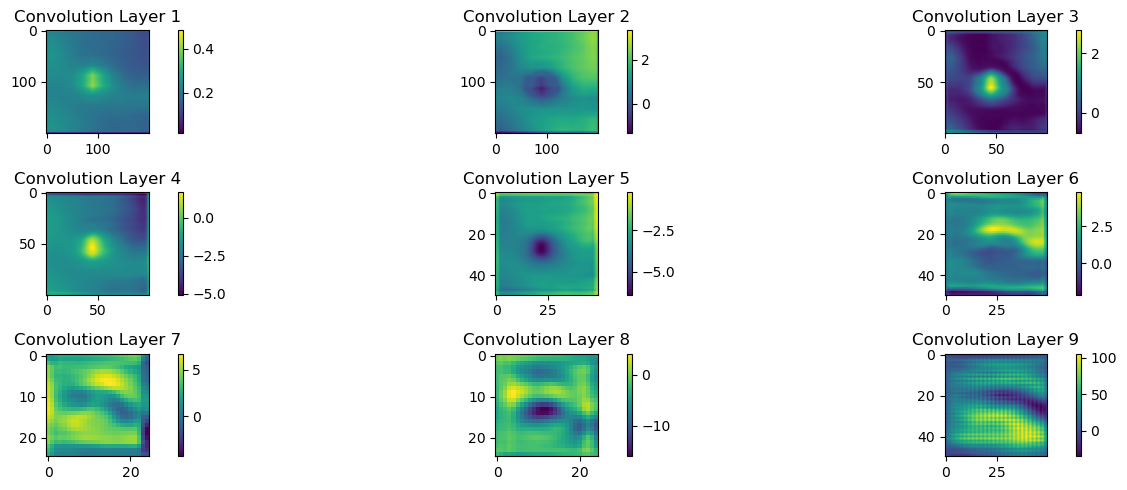

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Load or define the V-Net model
model = tf.keras.models.load_model("vnet_model.h5")  # If the model is saved as "vnet_model.h5"
# If you defined the model in the script, make sure to define it before this point

# Print model summary to check layer names
model.summary()

# Define a new model that outputs intermediate layer activations
intermediate_layer_model = tf.keras.Model(inputs=model.input,
                                          outputs=[model.get_layer('conv2d').output,
                                                   model.get_layer('conv2d_1').output,
                                                   model.get_layer('conv2d_2').output,
                                                   model.get_layer('conv2d_3').output,
                                                   model.get_layer('conv2d_4').output,
                                                   model.get_layer('conv2d_5').output,
                                                   model.get_layer('conv2d_6').output,
                                                   model.get_layer('conv2d_7').output,
                                                   model.get_layer('conv2d_8').output])

# Get sample input data (you can use any sample from your dataset)
sample_input = X_test[0:1]

# Extract intermediate layer outputs for the sample input
layer_outputs = intermediate_layer_model.predict(sample_input)

# Visualize the intermediate layer outputs
plt.figure(figsize=(15, 5))
for i, output in enumerate(layer_outputs):
    plt.subplot(3, 3, i+1)
    plt.title('Convolution Layer {}'.format(i+1))
    plt.imshow(output[0, :, :, 0], cmap='viridis')
    plt.colorbar()
plt.tight_layout()
plt.show()


Normal Model Architecture

In [ ]:
import tensorflow as tf

# Step 5: Define the model architecture
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(200, 200, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Step 6: Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Step 7: Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

# Step 8: Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {test_accuracy}')

# Step 9: Optionally, save the model
model.save('microbleed_detection_model')

Epoch 1/10
156/156 [==============================] - 105s 637ms/step - loss: 0.2216 - accuracy: 0.9068 - val_loss: 0.1116 - val_accuracy: 0.9582
Epoch 2/10
156/156 [==============================] - 118s 758ms/step - loss: 0.1287 - accuracy: 0.9542 - val_loss: 0.1011 - val_accuracy: 0.9550
Epoch 3/10
156/156 [==============================] - 114s 731ms/step - loss: 0.0935 - accuracy: 0.9659 - val_loss: 0.0709 - val_accuracy: 0.9791
Epoch 4/10
156/156 [==============================] - 132s 846ms/step - loss: 0.0840 - accuracy: 0.9727 - val_loss: 0.0638 - val_accuracy: 0.9767
Epoch 5/10
156/156 [==============================] - 120s 773ms/step - loss: 0.0791 - accuracy: 0.9743 - val_loss: 0.0720 - val_accuracy: 0.9751
Epoch 6/10
156/156 [==============================] - 105s 675ms/step - loss: 0.0875 - accuracy: 0.9691 - val_loss: 0.0767 - val_accuracy: 0.9783
Epoch 7/10
156/156 [==============================] - 104s 669ms/step - loss: 0.0803 - accuracy: 0.9715 - val_loss: 0.0413 -